In [49]:
import matplotlib.pyplot as plt
%matplotlib notebook
# %matplotlib ipympl
import pandas as pd
import numpy as np

#### Generate Dataframe of all keypoints from JSON file

In [50]:
keypoints_all = pd.read_json('./Keypoints_All.json', orient='records')
new_columns = ['Gesture', 'Sub folder No.', 'Frame No.', 'Person', 'Joint', 'X', 'Y', 'Probability', 'Depth']
keypoints_all = keypoints_all.reindex(columns = new_columns)
print('keypoints_all shape', keypoints_all.shape)
keypoints_all.head()

keypoints_all shape (181375, 9)


,Gesture,Sub folder No.,Frame No.,Person,Joint,X,Y,Probability,Depth
0,1,1,1,0,0,0.0,0.0,0.0,0.031373
1,1,1,1,0,1,0.0,0.0,0.0,0.031373
2,1,1,1,0,2,0.0,0.0,0.0,0.031373
3,1,1,1,0,3,0.0,0.0,0.0,0.031373
4,1,1,1,0,4,0.0,0.0,0.0,0.031373


#### Generate Dataframe of keypoints 1-7

In [51]:
keypoints_1_7 = keypoints_all[keypoints_all['Joint'].isin(range(1,8))]
print('keypoints_1_7 shape', keypoints_1_7.shape)

keypoints_1_7 shape (50785, 9)


#### Check Probability (from OpenPose output) per folder

<IPython.core.display.Javascript object>


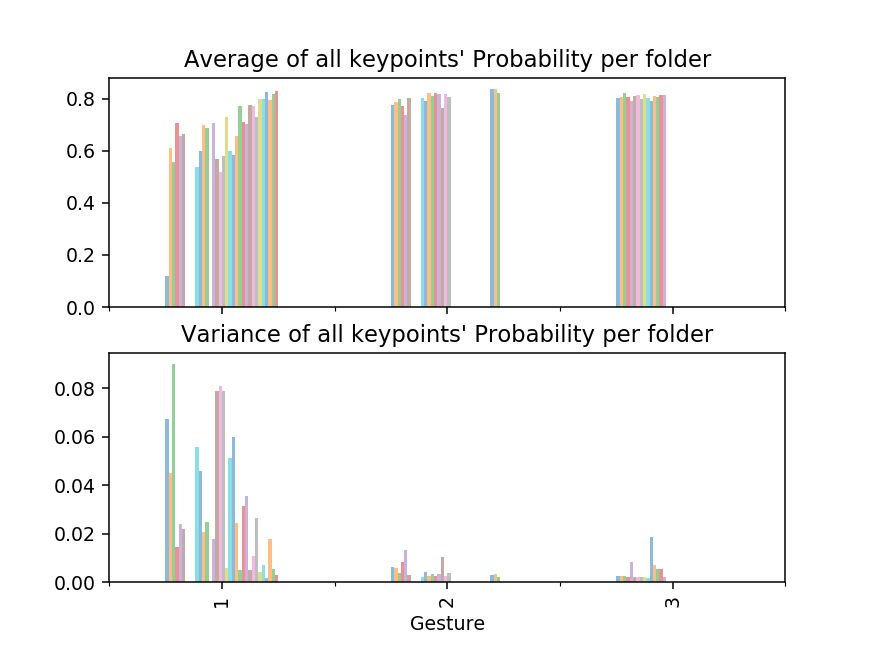

In [156]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=False, alpha=0.5)
pd.pivot_table(keypoints_1_7, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=False, alpha=0.5)

#### Observe distribution of Probability

<IPython.core.display.Javascript object>


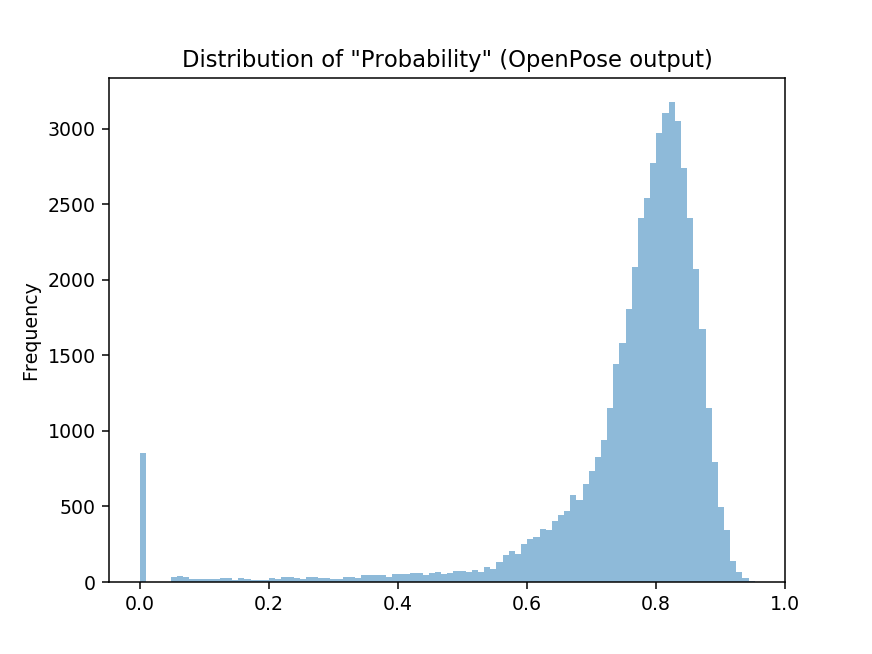

In [53]:
fig = plt.figure()
keypoints_1_7['Probability'].plot.hist(bins=100, title='Distribution of \"Probability\" (OpenPose output)', alpha=0.5)

#### Get Probability value at percentile 5, use it as probability threshold for later data cleaning

In [54]:
prob_threshold = keypoints_1_7['Probability'].quantile(0.05)
print(prob_threshold)

0.5051861882400001


#### Calculate the percentage of "low probability keypoints" (keypoints probability < probability threshold) per foler

<IPython.core.display.Javascript object>


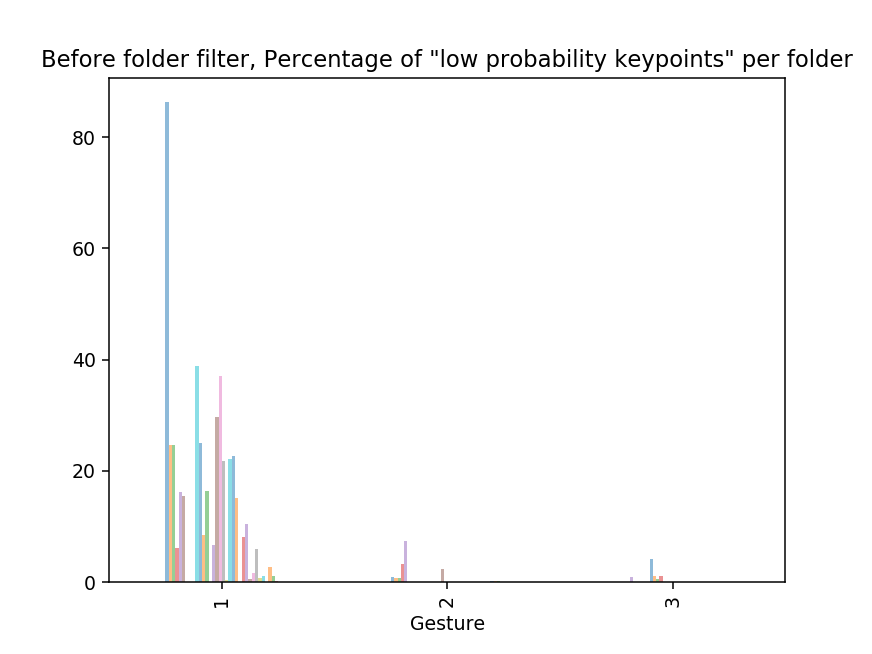

In [157]:
keypoints_1_7_folder_prob_threshold_percent = keypoints_1_7.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100)
keypoints_1_7_folder_prob_threshold_percent.plot.bar(title='Before folder filter, Percentage of \"low probability keypoints\" per folder', legend=False, alpha=0.5)

#### Filter the folders and keey only the folders has less than 10 percent of "low probability keypoints" 

In [56]:
low_prob_keypoints_percentage_threshold = 10
keypoints_1_7_folder_filtered_index = keypoints_1_7_folder_prob_threshold_percent[keypoints_1_7_folder_prob_threshold_percent['Probability'] < low_prob_keypoints_percentage_threshold].index.tolist()
keypoints_1_7_folder_filtered = keypoints_1_7[keypoints_1_7[['Gesture','Sub folder No.']].apply(lambda x:(x[0],x[1]) in keypoints_1_7_folder_filtered_index, axis=1)]

print('keypoints_1_7_filtered shape', keypoints_1_7_folder_filtered.shape)

keypoints_1_7_filtered shape (42819, 9)


<IPython.core.display.Javascript object>


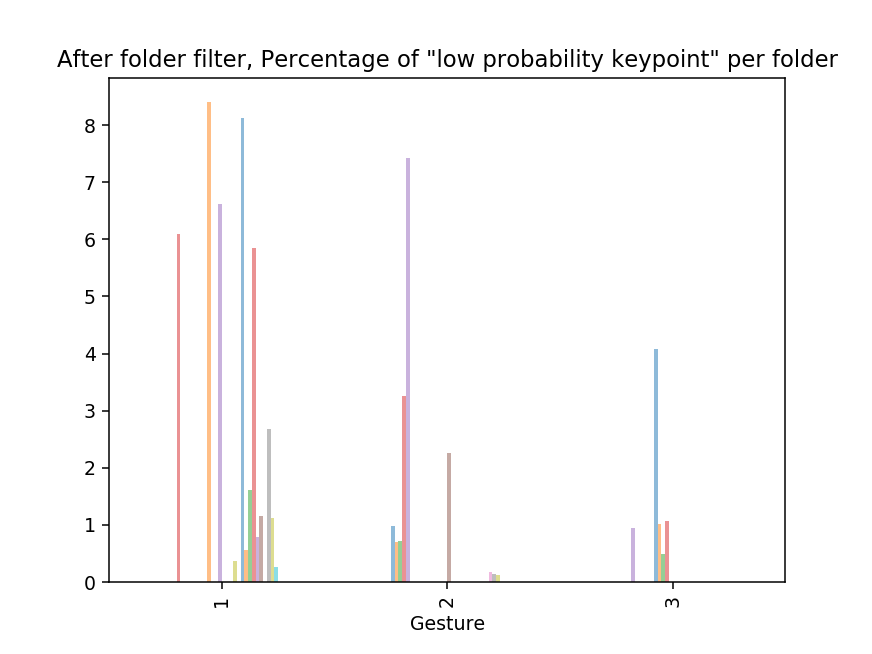

In [161]:
keypoints_1_7_folder_filtered.pivot_table(index = 'Gesture', columns = 'Sub folder No.', values='Probability', aggfunc = lambda x:np.count_nonzero(x<prob_threshold)/len(x)*100).plot.bar(title='After folder filter, Percentage of \"low probability keypoint\" per folder', legend=False, alpha=0.5)
plt.show()

<IPython.core.display.Javascript object>


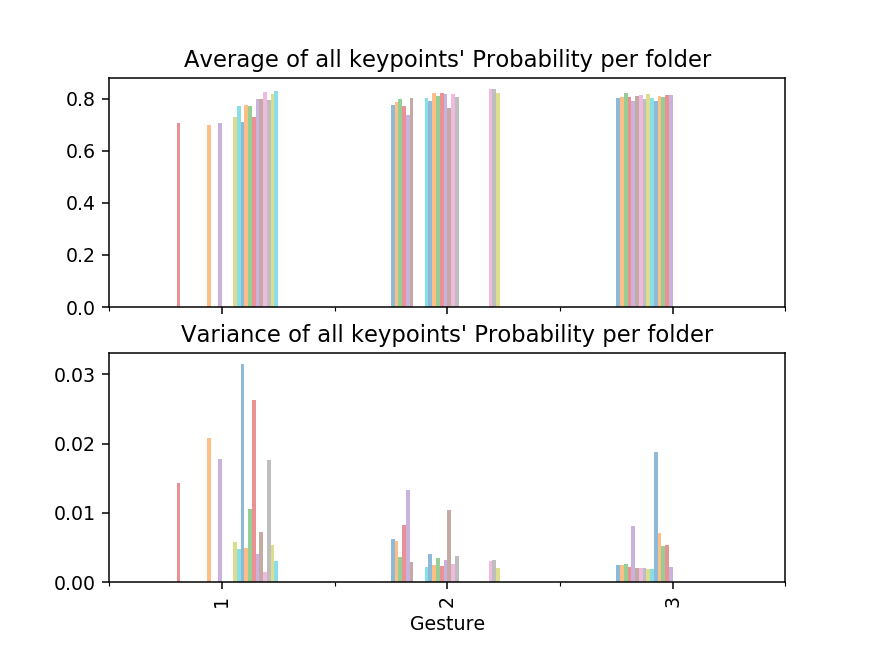

In [162]:
fig, axes = plt.subplots(2,1, sharex=True)
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='mean').plot(kind='bar', ax=axes[0], title='Average of all keypoints\' Probability per folder', legend=False, alpha=0.5)
pd.pivot_table(keypoints_1_7_folder_filtered, index='Gesture', columns = 'Sub folder No.', values='Probability', aggfunc='var').plot(kind='bar', ax=axes[1], title='Variance of all keypoints\' Probability per folder', legend=False, alpha=0.5)

#### Check the X values of Joint 3 in all frames, we can see there are 0 values, this also need to be cleaned

<IPython.core.display.Javascript object>


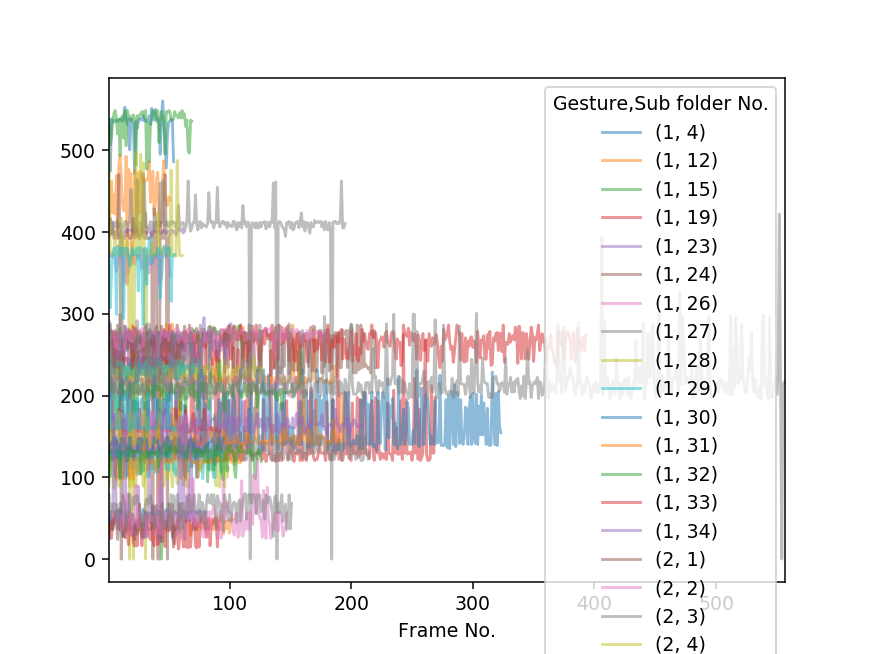

In [163]:
keypoints_1_7_folder_filtered[keypoints_1_7_folder_filtered['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X').plot.line(alpha=0.5)

#### We use Weighted Moving Average Smoothing to clean the 0 values of X and Y.
#### First, prepare a dataframe with t-1 and t+1 values for each keypoints

In [82]:
df = pd.concat([keypoints_1_7_folder_filtered, keypoints_1_7_folder_filtered.shift(7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t-1)', 'Y':'Y(t-1)', 'Probability':'Probability(t-1)'}), keypoints_1_7_folder_filtered.shift(-7)[['X', 'Y', 'Probability']].rename(columns={'X':'X(t+1)', 'Y':'Y(t+1)', 'Probability':'Probability(t+1)'})], axis=1)
df.head(14)

,Gesture,Sub folder No.,Frame No.,Person,Joint,X,Y,Probability,Depth,X(t-1),Y(t-1),Probability(t-1),X(t+1),Y(t+1),Probability(t+1)
4926,1,4,1,0,1,599.539856,117.944977,0.606791,0.341176,NaN,NaN,NaN,538.226440,120.586067,0.831424
4927,1,4,1,0,2,585.228027,110.167336,0.484397,0.501961,NaN,NaN,NaN,497.787415,130.999329,0.744093
4928,1,4,1,0,3,530.401123,174.084900,0.800581,0.733333,NaN,NaN,NaN,474.329376,202.840897,0.887369
4929,1,4,1,0,4,527.758240,129.748550,0.760209,0.705882,NaN,NaN,NaN,433.882629,258.918304,0.834839
4930,1,4,1,0,5,610.026001,121.889938,0.664449,0.333333,NaN,NaN,NaN,577.405212,111.475510,0.703935
4931,1,4,1,0,6,569.547424,213.194748,0.837365,0.325490,NaN,NaN,NaN,611.282471,201.496506,0.811391
4932,1,4,1,0,7,486.079956,192.379120,0.828425,0.415686,NaN,NaN,NaN,547.374878,254.978317,0.840501
4951,1,4,2,0,1,538.226440,120.586067,0.831424,0.454902,599.539856,117.944977,0.606791,587.830200,108.876297,0.653654
4952,1,4,2,0,2,497.787415,130.999329,0.744093,0.635294,585.228027,110.167336,0.484397,568.263733,106.234604,0.543617
4953,1,4,2,0,3,474.329376,202.840897,0.887369,0.627451,530.401123,174.084900,0.800581,538.255554,157.121521,0.425784


#### Use Weighted Moving Average Smoothing to calculate X_cleaned and Y_cleaned

In [83]:
X_cleaned = df.apply(lambda row: (row['X']*row['Probability'] + row['X(t-1)']*row['Probability(t-1)'] + row['X(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['X'], axis=1)
Y_cleaned = df.apply(lambda row: (row['Y']*row['Probability'] + row['Y(t-1)']*row['Probability(t-1)'] + row['Y(t+1)']*row['Probability(t+1)'])/(row['Probability']+row['Probability(t-1)']+row['Probability(t+1)']) if row['Probability']==0 else row['Y'], axis=1)

#### Add cleaned X and Y to the original dataframe

In [85]:
keypoints_1_7_frame_cleaned = pd.concat([keypoints_1_7_folder_filtered, X_cleaned.rename('X_cleaned'), Y_cleaned.rename('Y_cleaned')], axis=1)
keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

,Gesture,Sub folder No.,Frame No.,Person,Joint,X,Y,Probability,Depth,X_cleaned,Y_cleaned
13504,1,12,34,0,4,0.0,0.0,0.0,0.039216,428.795566,193.354531
16331,1,15,29,0,6,0.0,0.0,0.0,0.917647,617.835623,193.691148
16332,1,15,29,0,7,0.0,0.0,0.0,0.917647,550.622166,175.391640
16581,1,15,39,0,6,0.0,0.0,0.0,0.925490,611.923678,193.682379
16582,1,15,39,0,7,0.0,0.0,0.0,0.925490,544.732730,181.237718


#### Recheck the X values of Joint 3 in all frames, we can see no more 0 values

<IPython.core.display.Javascript object>


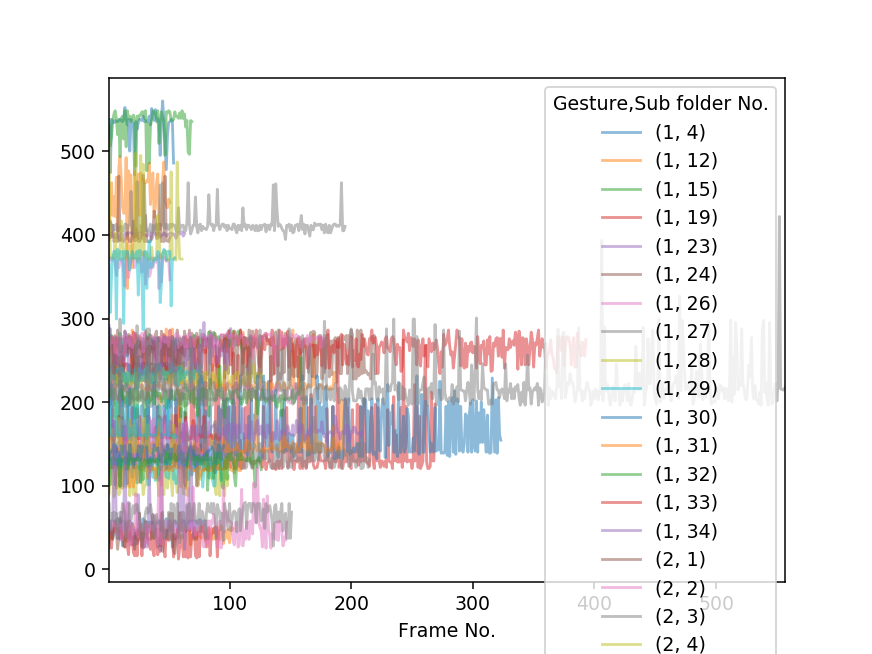

In [164]:
keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='X_cleaned').plot.line(alpha=0.5)

#### After data cleaning of OpenPose data, we also need to clean depth data

#### Check the depth value when probability == 0 (aka. X==0 and Y==0)

In [68]:
keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].pivot_table(index = ['Frame No.', 'Joint'], columns = ['Gesture', 'Sub folder No.'], values='Depth').swapaxes(axis1=0, axis2=1)

Frame No.                    9         11                  16        18   \
Joint                          4         3         4         4         3   
Gesture Sub folder No.                                                     
1       12                   NaN       NaN       NaN       NaN       NaN   
        15                   NaN       NaN       NaN       NaN       NaN   
        24              0.976471  0.976471  0.976471       NaN       NaN   
        27                   NaN       NaN       NaN       NaN       NaN   
        28                   NaN       NaN       NaN       NaN  0.980392   
        32                   NaN       NaN       NaN  0.980392       NaN   
2       1                    NaN       NaN       NaN       NaN       NaN   
        2                    NaN       NaN       NaN       NaN       NaN   
        31                   NaN       NaN       NaN       NaN       NaN   
        32                   NaN       NaN       NaN       NaN       NaN   
3       5                    NaN       NaN       NaN       NaN       NaN   
        12                   NaN       NaN       NaN       NaN       NaN   
        13                   NaN       NaN       NaN       NaN       NaN   
        14                   NaN       NaN       NaN       NaN       NaN   

Frame No.                              21                  23        27   ...  \
Joint                          4         3         4         4         4  ...   
Gesture Sub folder No.                                                    ...   
1       12                   NaN       NaN       NaN       NaN       NaN  ...   
        15                   NaN       NaN       NaN       NaN       NaN  ...   
        24                   NaN       NaN       NaN       NaN       NaN  ...   
        27                   NaN       NaN       NaN       NaN       NaN  ...   
        28              0.980392  0.980392  0.980392  0.976471  0.976471  ...   
        32                   NaN       NaN       NaN  0.980392       NaN  ...   
2       1                    NaN       NaN       NaN       NaN  0.031373  ...   
        2                    NaN       NaN       NaN       NaN       NaN  ...   
        31                   NaN       NaN       NaN       NaN       NaN  ...   
        32                   NaN       NaN       NaN       NaN       NaN  ...   
3       5                    NaN       NaN       NaN       NaN       NaN  ...   
        12                   NaN       NaN       NaN       NaN       NaN  ...   
        13                   NaN       NaN       NaN       NaN       NaN  ...   
        14                   NaN       NaN       NaN       NaN       NaN  ...   

Frame No.                    184                241                360  \
Joint                          3         4        6        7         4   
Gesture Sub folder No.                                                   
1       12                   NaN       NaN      NaN      NaN       NaN   
        15                   NaN       NaN      NaN      NaN       NaN   
        24                   NaN       NaN      NaN      NaN       NaN   
        27              0.976471  0.976471      NaN      NaN       NaN   
        28                   NaN       NaN      NaN      NaN       NaN   
        32                   NaN       NaN      NaN      NaN       NaN   
2       1                    NaN       NaN      NaN      NaN       NaN   
        2                    NaN       NaN      NaN      NaN       NaN   
        31                   NaN       NaN      NaN      NaN       NaN   
        32                   NaN       NaN      NaN      NaN       NaN   
3       5                    NaN       NaN  0.92549  0.92549  0.976471   
        12                   NaN       NaN      NaN      NaN       NaN   
        13                   NaN       NaN      NaN      NaN       NaN   
        14                   NaN       NaN      NaN      NaN       NaN   

Frame No.                   552       554                             

#### When Probability == 0, it means that the keypoint is occluded. To estimate the depth value, we use Moving Average Smoothing: get average of depth data at t-1 and t+1

In [98]:
df = pd.concat([keypoints_1_7_frame_cleaned, keypoints_1_7_frame_cleaned.shift(7)['Depth'].rename('Depth(t-1)'), keypoints_1_7_frame_cleaned.shift(-7)['Depth'].rename('Depth(t+1)')], axis=1)
Depth_cleaned = df[['Probability', 'Depth', 'Depth(t-1)', 'Depth(t+1)']].apply(lambda x: np.mean((x[2], x[3])) if x[0]==0 else x[1], axis=1)
keypoints_1_7_frame_cleaned['Depth_cleaned'] = Depth_cleaned
keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Probability']==0].head()

,Gesture,Sub folder No.,Frame No.,Person,Joint,X,Y,Probability,Depth,X_cleaned,Y_cleaned,depth_cleaned,Depth_cleaned
13504,1,12,34,0,4,0.0,0.0,0.0,0.039216,428.795566,193.354531,0.213072,0.300000
16331,1,15,29,0,6,0.0,0.0,0.0,0.917647,617.835623,193.691148,0.322876,0.025490
16332,1,15,29,0,7,0.0,0.0,0.0,0.917647,550.622166,175.391640,0.350327,0.066667
16581,1,15,39,0,6,0.0,0.0,0.0,0.925490,611.923678,193.682379,0.329412,0.031373
16582,1,15,39,0,7,0.0,0.0,0.0,0.925490,544.732730,181.237718,0.354248,0.068627


#### Now check the depth data of Joint 3 in all frames, we can see abnormal depth values (noise)

<IPython.core.display.Javascript object>


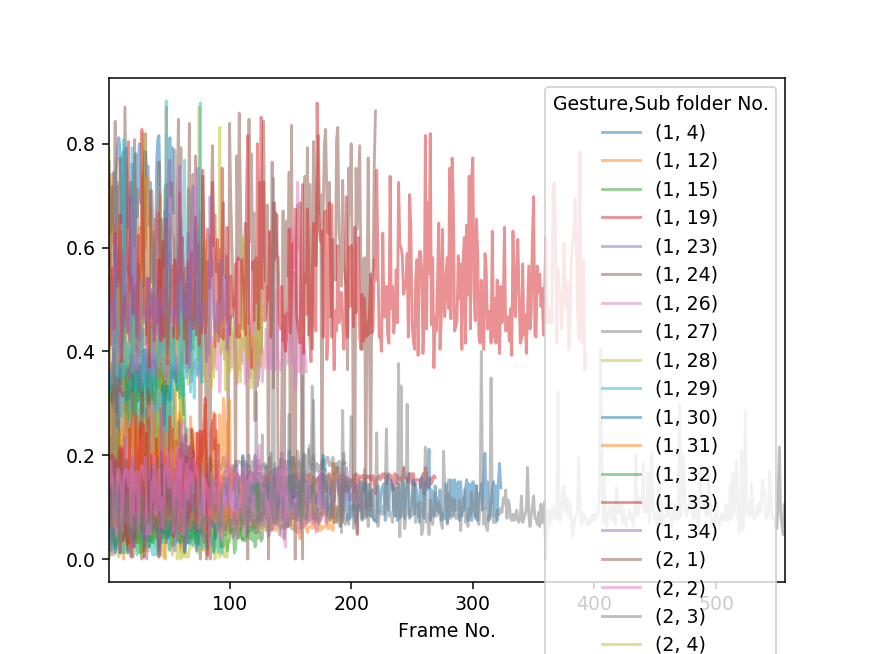

In [165]:
keypoints_1_7_frame_cleaned[keypoints_1_7_frame_cleaned['Joint']==3].pivot_table(index = 'Frame No.', columns = ['Gesture', 'Sub folder No.'], values='Depth_cleaned').plot.line(alpha=0.5)

<IPython.core.display.Javascript object>


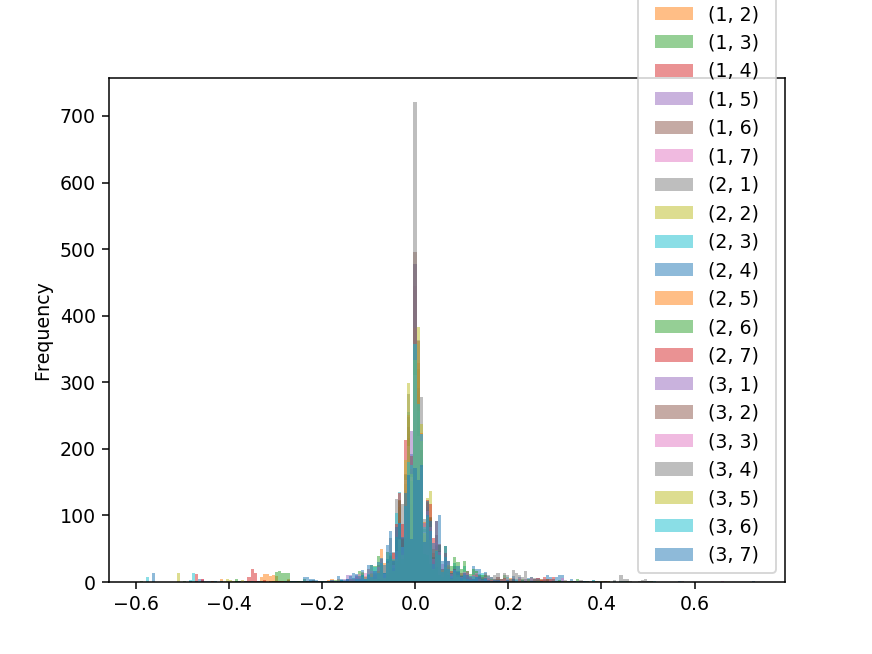

In [166]:
Depth_median = keypoints_1_7_frame_cleaned.pivot_table(index = ['Gesture', 'Sub folder No.', 'Joint'], values = 'Depth_cleaned', aggfunc = lambda x: np.median(x)).rename(columns={'Depth_cleaned':'Depth_median'})
df = keypoints_1_7_frame_cleaned.join(Depth_median, on=['Gesture', 'Sub folder No.', 'Joint'])
df['Depth_cleaned - Depth_median'] = df['Depth_cleaned'] - df['Depth_median']
df.pivot_table(index = ['Sub folder No.', 'Frame No.'], columns = ['Gesture', 'Joint'], values = 'Depth_cleaned - Depth_median').plot.hist(bins=200, alpha=0.5)